In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix , recall_score , classification_report

In [2]:
transform = transforms.Compose([
    transforms.ToTensor() ,
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST(root = 'data', download = True , train = True , transform=transform)
testset = datasets.MNIST(root = 'data' , download = True , train = False , transform=transform)

train = DataLoader(trainset , batch_size= 64 , shuffle = True)
test = DataLoader(testset , batch_size= 1000 , shuffle = True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.48MB/s]


batch images shape :  torch.Size([64, 1, 28, 28])
batch size =  torch.Size([64])


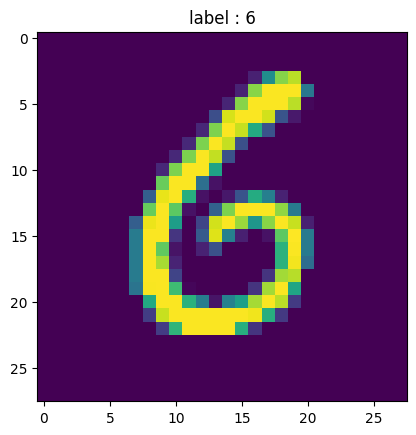

In [3]:
for i , l in train :
  print("batch images shape : ",i.shape)
  print('batch size = ',l.shape)
  break

classes = [0,1,2,3,4,5,6,7,8,9]
def show(index):
    img = i[index]
    imgnp = img.numpy()
    img = imgnp.transpose(1, 2, 0)
    plt.imshow(img)
    plt.title(f"label : {classes[l[index]]}")
show(1)

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)  # skip path

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = F.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer2 = BasicBlock(32, 32)
        self.layer3 = BasicBlock(32, 64, stride=2)  # downsample
        self.layer4 = BasicBlock(64, 128, stride=2) # downsample

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
model = ResNet().to(device)
cretireon = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001)
epochs = 5
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    start = time.time()
    for images , labels in train:
        images , labels = images.to(device) , labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = cretireon(predictions , labels)
        running_loss += loss.item()
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    end = time.time()
    print(f"{epoch+1}/{epochs} : loss = {running_loss/len(train):.3f} | time = {end - start:.2f}s")

1/5 : loss = 0.168 | time = 18.17s
2/5 : loss = 0.040 | time = 17.85s
3/5 : loss = 0.030 | time = 19.33s
4/5 : loss = 0.024 | time = 16.81s
5/5 : loss = 0.022 | time = 18.11s


In [11]:
corrects = 0
total = 0
trues = []
predicted = []

model.eval()
with torch.no_grad() :
  for img , labs in test :
     img , labs = img.to(device) , labs.to(device)
     preds = model(img)
     predicts = torch.argmax(preds , dim=1)
     comp = (predicts == labs).sum().item()
     corrects += comp
     total += labs.size(0)
     trues.extend(labs.cpu().tolist())
     predicted.extend(predicts.cpu().tolist())

accuracy = 100 * corrects / total
print(f"accuracy = {accuracy:.2f}%")

accuracy = 99.08%


recall score : 99.08%
confusion matrix : 
 [[ 975    0    1    0    0    0    0    2    1    1]
 [   5 1127    1    0    0    0    1    1    0    0]
 [   0    1 1024    0    0    0    0    6    1    0]
 [   0    0    1  993    0    9    0    3    4    0]
 [   0    0    0    0  968    0    2    1    3    8]
 [   0    0    0    3    0  887    1    1    0    0]
 [   4    5    1    0    0    1  947    0    0    0]
 [   0    6    0    0    0    0    0 1022    0    0]
 [   0    1    3    0    0    2    1    1  966    0]
 [   0    0    0    0    5    0    1    3    1  999]]


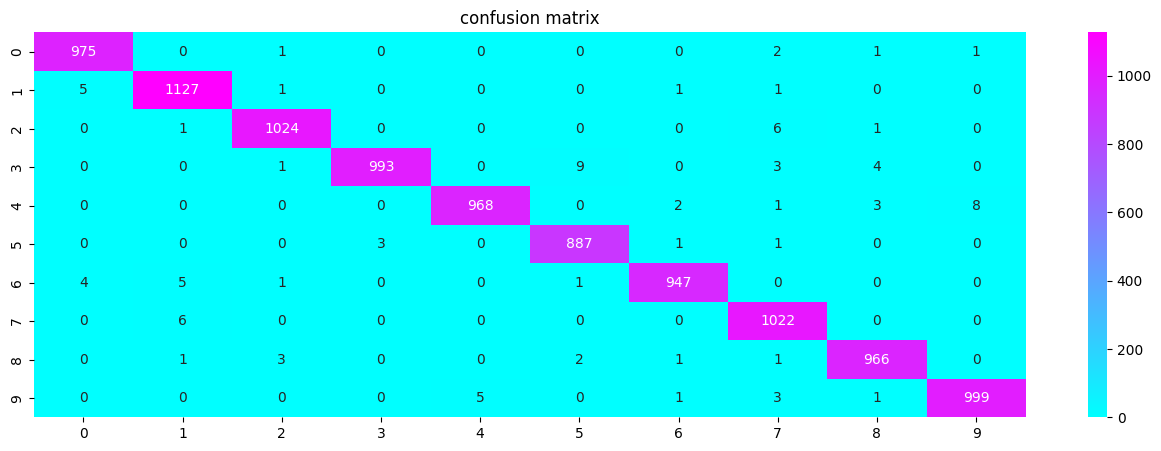

In [30]:
recall = recall_score(trues , predicted , average='micro')
cm = confusion_matrix(trues , predicted)
print(f"recall score : {recall*100:.2f}%")
print("confusion matrix : \n", cm)
plt.figure(figsize=(16 , 5))
sns.heatmap(cm , annot = True , fmt = 'd', cmap = 'cool')
plt.title("confusion matrix")
plt.show()

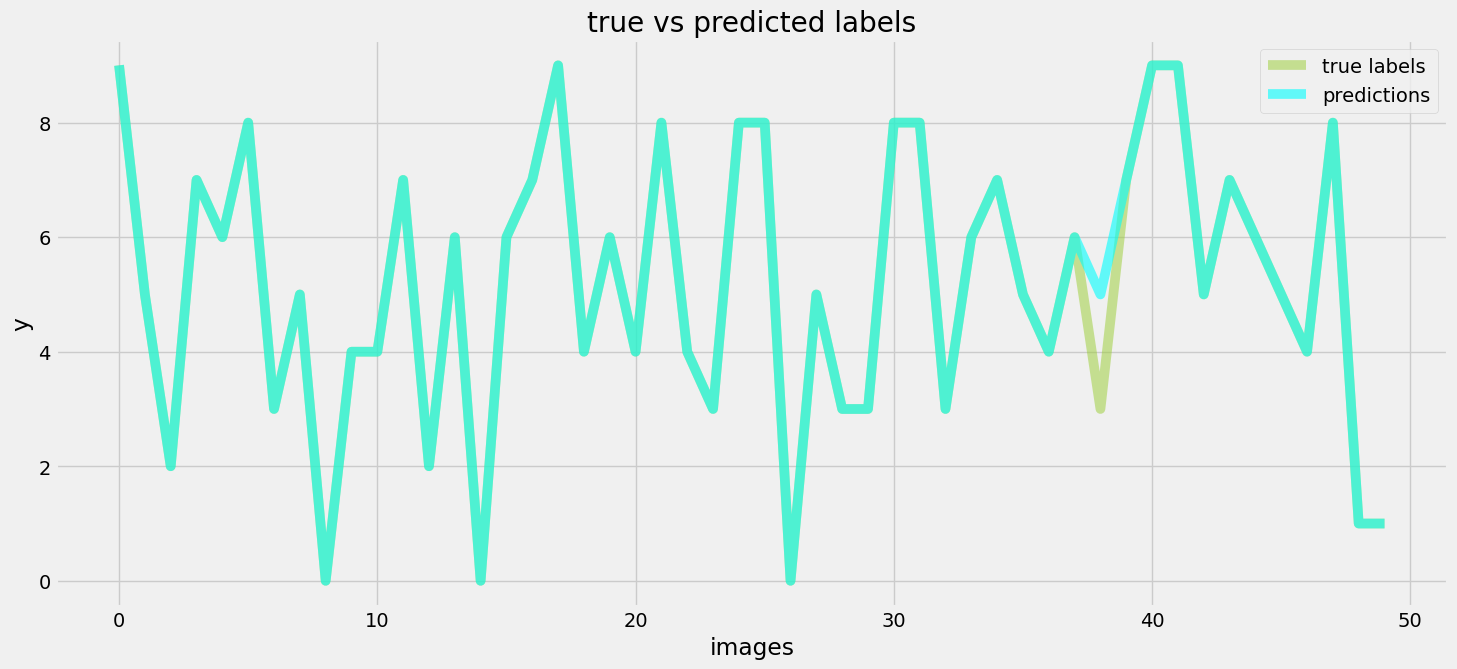

In [54]:
plt.figure(figsize=(16 , 7))
plt.plot(trues[50:100] , c='yellowgreen' , label = 'true labels' , linewidth = 7,  alpha = 0.5)
plt.plot(predicted[50:100] , c= 'cyan' , label = 'predictions' , linewidth = 7 , alpha = 0.6)
plt.legend()
plt.xlabel('images')
plt.ylabel("y")
plt.title("true vs predicted labels")
plt.show()

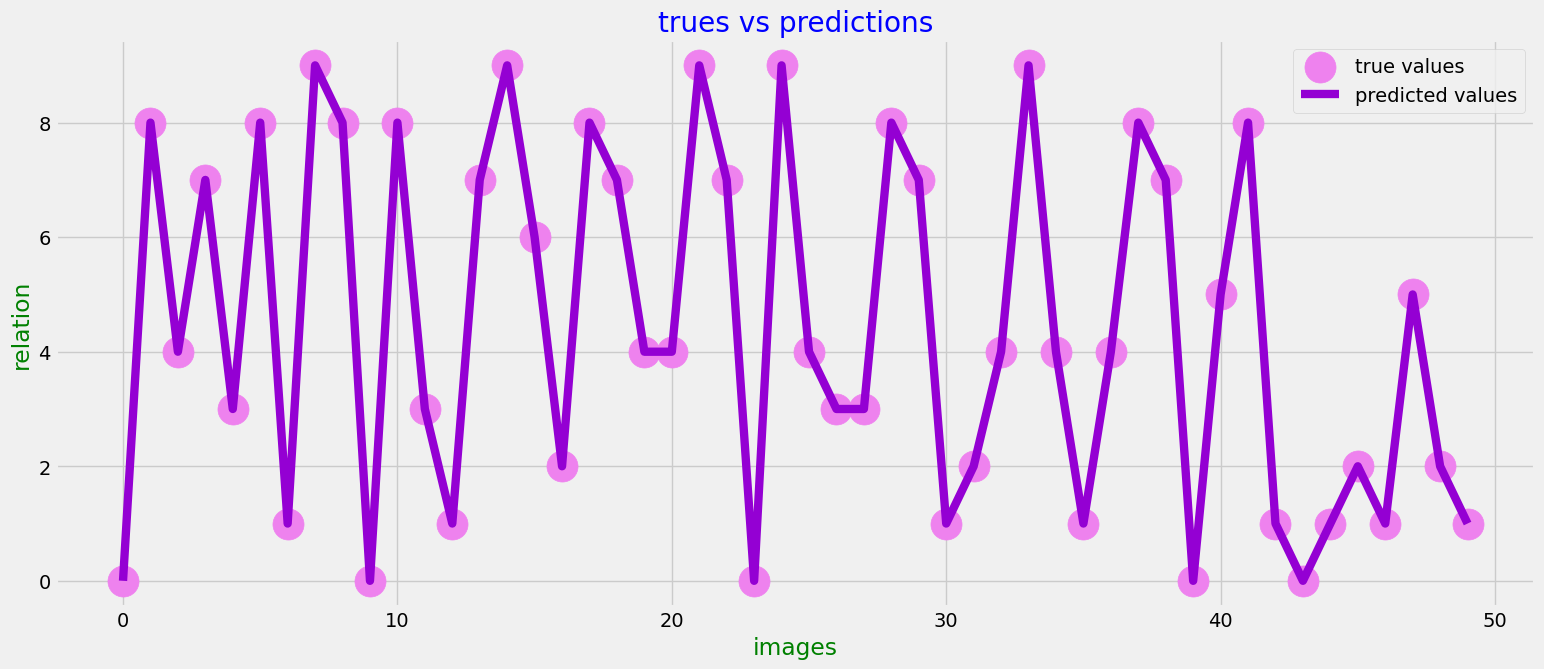

In [45]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(17 , 7))
plt.scatter(range(50) , trues[:50], color='violet', label = 'true values' , s = 500)
plt.plot(range(50) , predicted[:50] , linewidth = 6 , c='darkviolet' , label = 'predicted values')
plt.xlabel("images", color='green')
plt.ylabel("relation", color='green')
plt.title("trues vs predictions", color='blue')
plt.legend()
plt.show()

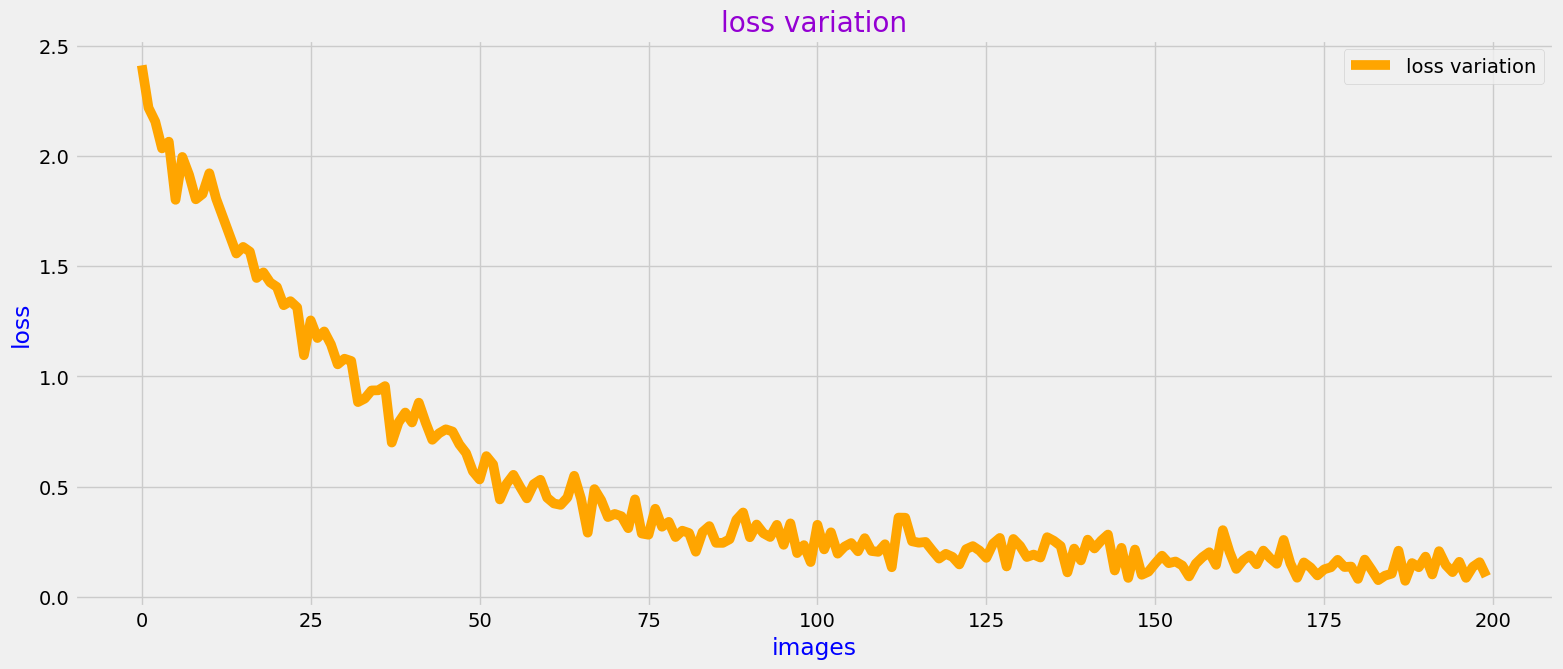

In [68]:
plt.figure(figsize=(17 , 7))
plt.plot(range(200) , losses[:200] , c='orange' , label = 'loss variation', linewidth = 7)
plt.xlabel("images" , color = 'blue')
plt.ylabel("loss" , color = 'blue')
plt.title("loss variation", color = 'darkviolet')
plt.legend()
plt.show()

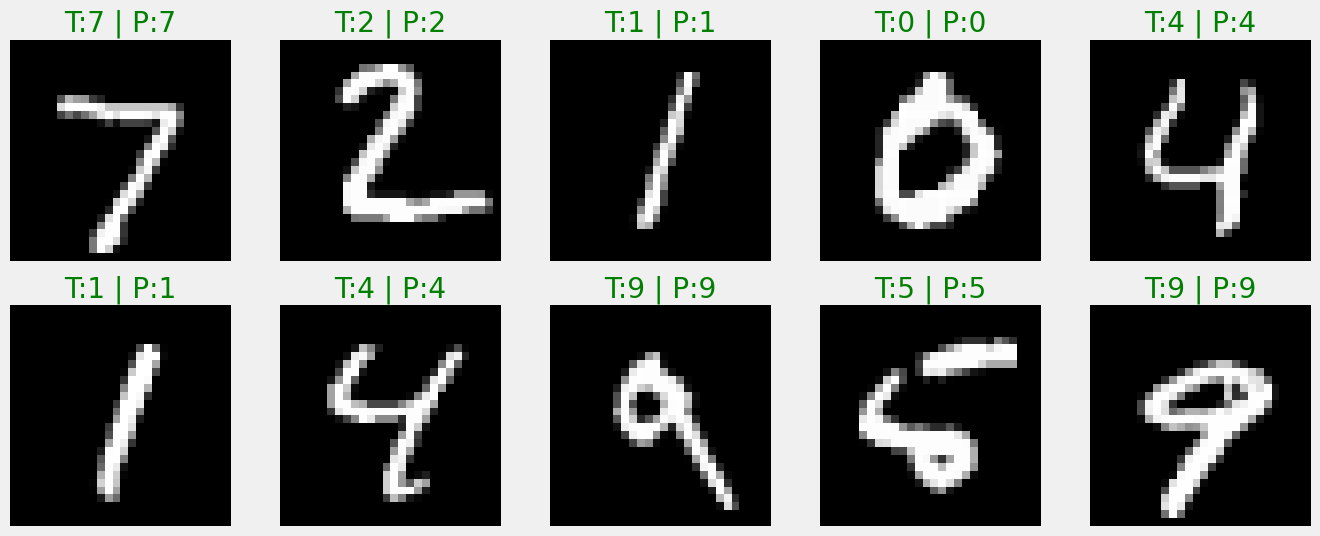

In [69]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i, ax in enumerate(axes.flatten()):
    img, label = testset[i]
    model.eval()
    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)
        pred = torch.argmax(model(img_input), dim=1).item()
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"T:{label} | P:{pred}" , color='green')
    ax.axis('off')
plt.show()

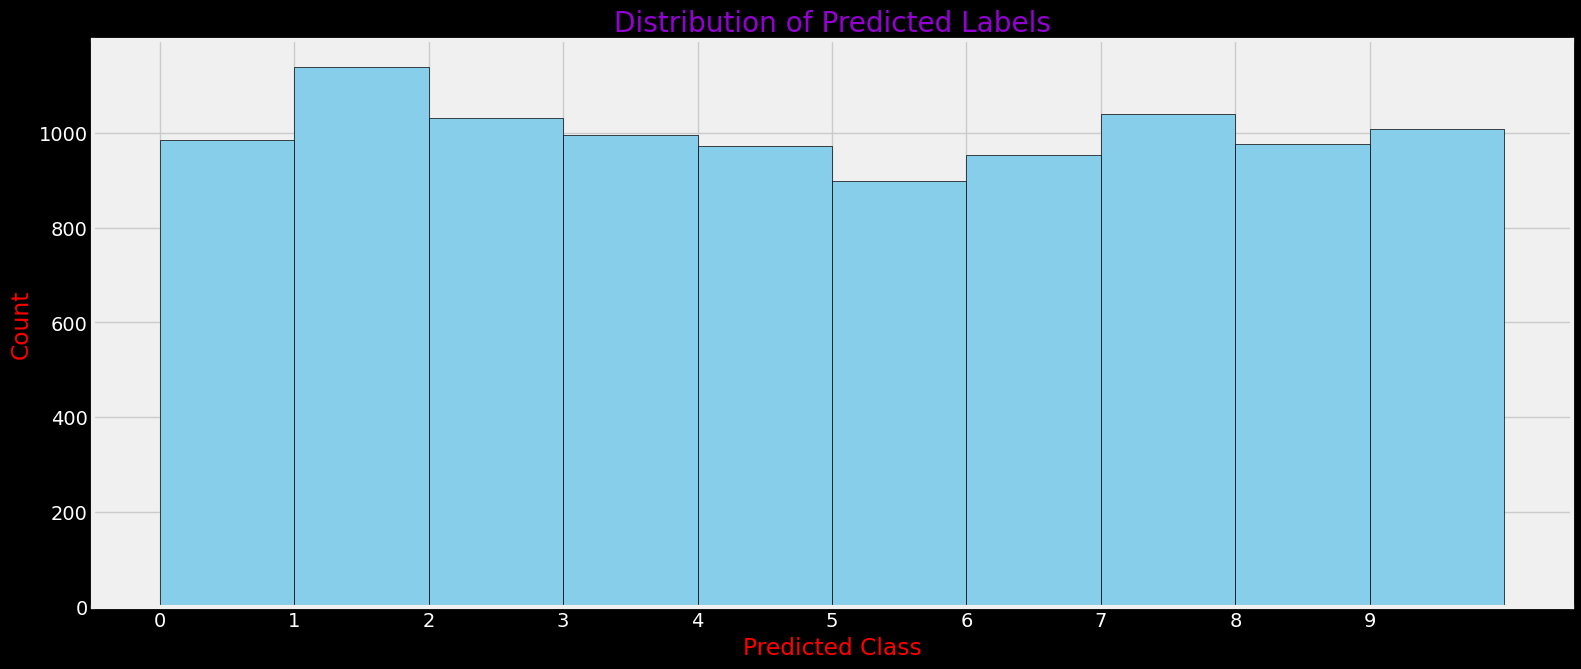

In [71]:
plt.figure(figsize=(17 , 7))
plt.style.use('fivethirtyeight')
plt.hist(predicted, bins=range(11), color='skyblue', edgecolor='black')
plt.xticks(range(10))
plt.xlabel("Predicted Class" , color = 'red')
plt.ylabel("Count", color = 'red')
plt.title("Distribution of Predicted Labels", color = 'darkviolet')
plt.show()